# Wasserstein GAN

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from google.colab import drive
drive.mount('/content/drive')

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Generator/discriminator implementation

In [ ]:
class Discriminator(nn.Module):
    """
    Input: [B, 3, 64, 64]
    Output: [B, ]
    """
    def __init__(self, in_channels=3, weight_init=False):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        )
        if weight_init:
            self.apply(self._initialize_weights)

    def forward(self, x):
        x = self.net(x).view(-1, 1).squeeze(1)
        return nn.Sigmoid()(x)

    def _initialize_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)

class Generator(nn.Module):
    """
    Input: [B, 100, 1, 1]
    Output: [B, 3, 64, 54]
    """
    def __init__(self, out_channels=3, weight_init=False):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, out_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        if weight_init:
            self.apply(self._initialize_weights)

    def forward(self, z):
        return self.net(z)

    def _initialize_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)

class WGAN(nn.Module):
    def __init__(self, channels=3, weight_init=False):
        super(WGAN, self).__init__()
        self.generator = Generator(out_channels=channels, weight_init=weight_init)
        self.discriminator = Discriminator(in_channels=channels, weight_init=weight_init)

    def sample(self, n_samples, device="cpu"):
        fixed_noise = torch.randn(n_samples, 100, 1, 1).to(device)
        samples = self.generator(fixed_noise)
        samples = ((samples + 1) * 0.5)
        samples = samples.clamp(0, 1)
        samples = samples.cpu().detach().numpy()
        samples = np.transpose(samples, (0, 2, 3, 1))
        return samples

## MNIST

In [ ]:
train_set = torchvision.datasets.MNIST(root="./data", download=True, transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,
                                         shuffle=True, num_workers=2)

In [ ]:
model = WGAN(channels=1, weight_init=True).to(DEVICE)
optimizerD = optim.Adam(model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(model.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
train(model, train_loader, optimizerD, optimizerG, epochs=10)

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Deep unsupervised learning/GAN/WGAN_mnist.pt")

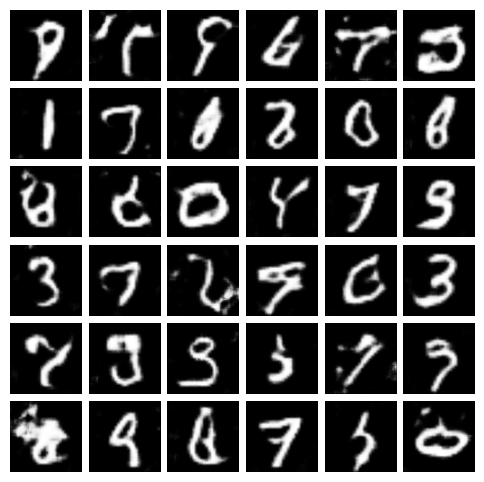

In [ ]:
samples = model.sample(36, device=DEVICE)
fig, ax = plt.subplots(6, 6, figsize=(6, 6))
ax = ax.flatten()
for i in range(36):
    ax[i].imshow(samples[i], cmap="gray")
    ax[i].axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Training loop

In [ ]:
train_set = torchvision.datasets.CIFAR10(root="./data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,
                                         shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:05<00:00, 32041568.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
def plot_samples(samples, m=1, n=6, title="Generated samples"):
    fig, ax = plt.subplots(m, n, figsize=(10, 2))
    ax = ax.flatten()
    for i in range(m*n):
        ax[i].imshow(samples[i])
        ax[i].axis("off")
    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

def train_epoch(model, optimizerD, optimizerG, train_loader, epoch_num=1, device=DEVICE, sample=True, n_critic=1):
    model.train()
    discriminator = model.discriminator
    generator = model.generator
    discriminator_loss = 0.0
    generator_loss = 0.0
    for i, (X, _) in enumerate(train_loader):
        X = X.to(DEVICE)
        mean_D_loss = 0.0
        optimizerD.zero_grad()

        for _ in range(n_critic):
            noise = torch.randn(X.size(0), 100, 1, 1).to(DEVICE)
            X_fake = generator(noise)
            D_fake = discriminator(X_fake.detach())
            D_real = discriminator(X)
            W_D_loss = torch.mean(D_fake - D_real)
            W_D_loss.backward(retain_graph=True)
            optimizerD.step()

            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)

        optimizerG.zero_grad()
        X_fake = generator(noise)
        D_fake = discriminator(X_fake)
        W_G_loss = -torch.mean(D_fake)
        W_G_loss.backward()
        optimizerG.step()

        discriminator_loss += W_D_loss.item()
        generator_loss += W_G_loss.item()
    discriminator_loss /= len(train_loader)
    generator_loss /= len(train_loader)
    discriminator_loss = round(discriminator_loss, 5)
    generator_loss = round(generator_loss, 5)

    if sample:
        samples = model.sample(6, device=DEVICE)
        plot_samples(samples, title=f"Epoch {epoch_num} generated samples with D loss: {discriminator_loss}, G loss: {generator_loss}")

def train(model, train_loader, optimizerD, optimizerG, epochs, n_critic=1):
    for epoch in range(epochs):
        train_epoch(model, optimizerD, optimizerG, train_loader, epoch_num=epoch, sample=True, n_critic=n_critic)

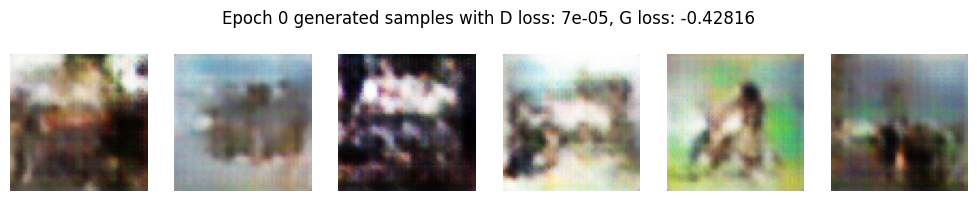

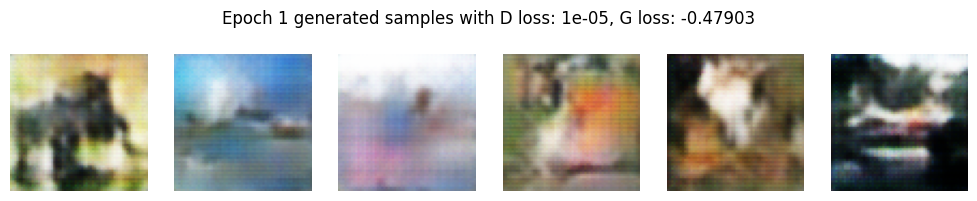

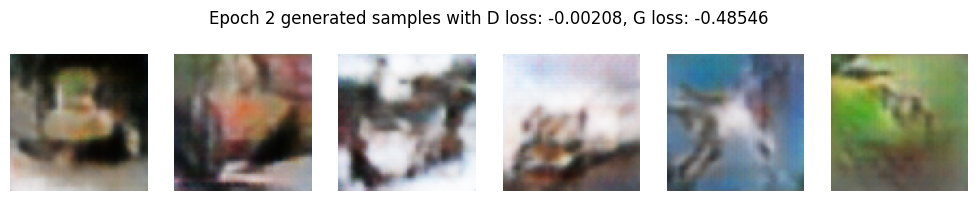

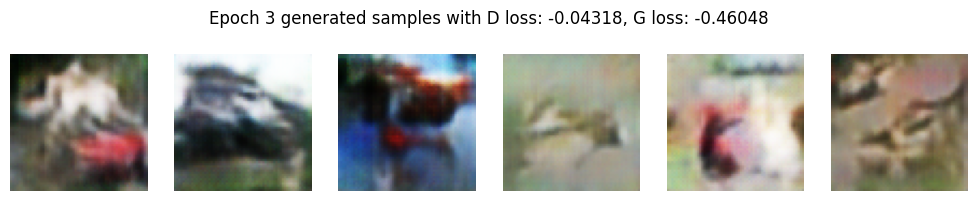

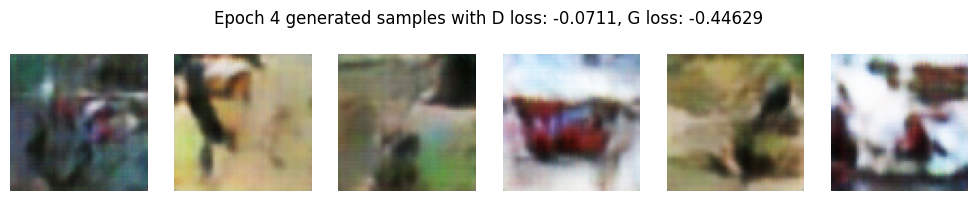

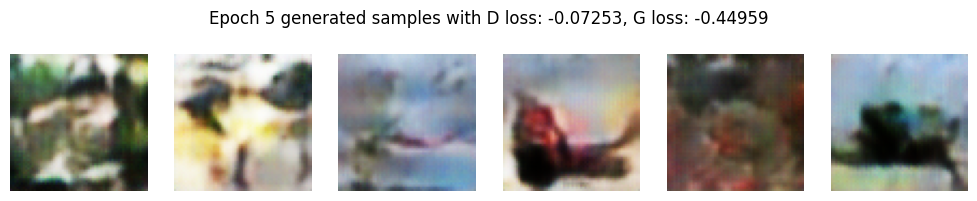

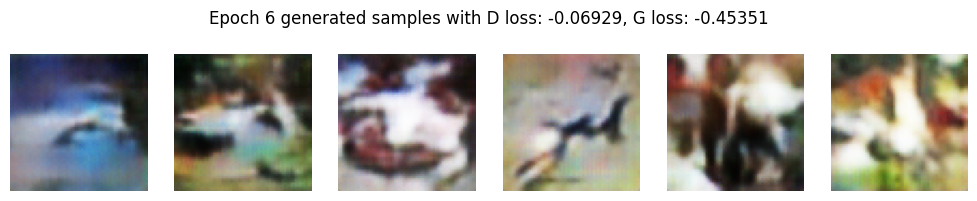

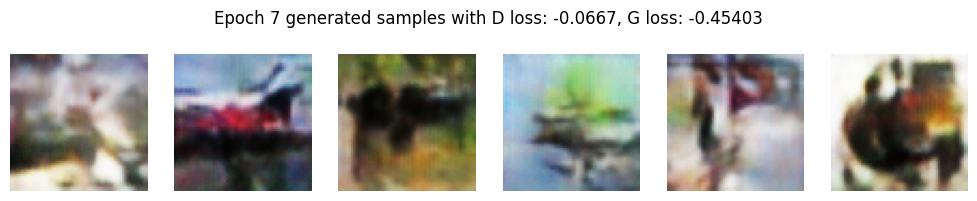

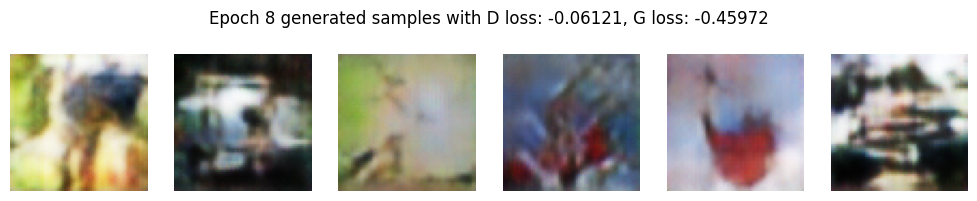

KeyboardInterrupt: 

In [ ]:
model = WGAN(weight_init=True).to(DEVICE)
model.load_state_dict(torch.load("/content/drive/MyDrive/Deep unsupervised learning/GAN/WGAN_cifar10.pt"))
optimizerD = optim.RMSprop(model.discriminator.parameters(), lr=0.0002)
optimizerG = optim.RMSprop(model.generator.parameters(), lr=0.0002)
train(model, train_loader, optimizerD, optimizerG, epochs=10)

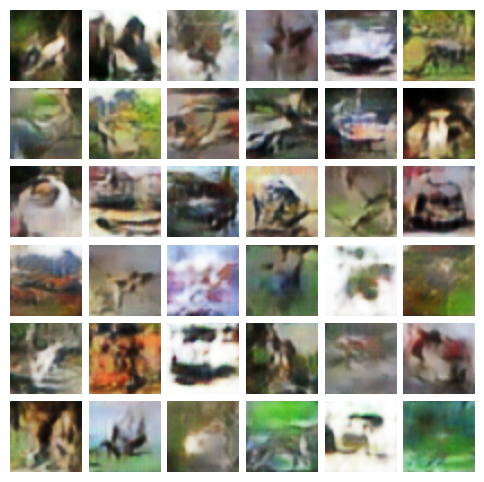

In [ ]:
model.eval()
samples = model.sample(36, device=DEVICE)
fig, ax = plt.subplots(6, 6, figsize=(6, 6))
ax = ax.flatten()
for i in range(36):
    ax[i].imshow(samples[i])
    ax[i].axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

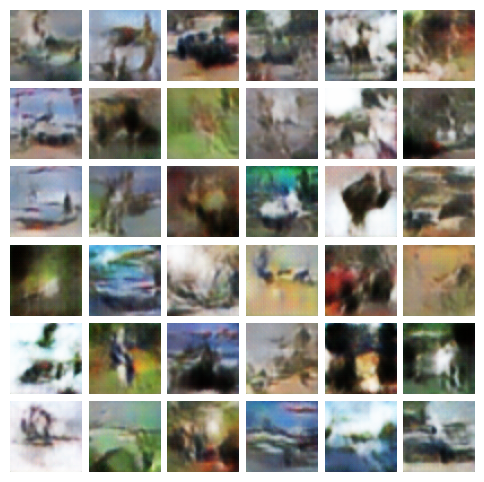

In [ ]:
model.eval()
samples = model.sample(36, device=DEVICE)
fig, ax = plt.subplots(6, 6, figsize=(6, 6))
ax = ax.flatten()
for i in range(36):
    ax[i].imshow(samples[i])
    ax[i].axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()